# How to use the Multiparameter persistence Module Approximation library.
This notebook provides a detailed example using the main functions of this library.

## Setup

The easiest way to compile / install this python library is using pip :

In [1]:
# ! pip install --user src/ 

In [2]:
import matplotlib.pyplot as plt		# Plot library of Python.
import gudhi as gd   				# TDA library. This will help us generate chain complexes with the simplextree structure.
import numpy as np   				# As math in python is broken we need numpy 
from mma import approx, splx2bf		# Our python library to approximate n-persistence modules.

## Synthetic example

In this case we will take a simple simplextree to create a circle, but in a "real usecase" you will want to take a simplextree generated via a dataset. 

In [3]:
simplextree = gd.SimplexTree()     # SimplexTree is the data structure of gudhi to hold filtered complexes
simplextree.insert([0,1,2])        # we add the triangle 0-1-2 to the complex.

True

In [4]:
#
#    0---2
#    |**/
#    |*/
#    |/
#    1
#

### Consider a bi-filtration ie. a list of filtrations of the simplices

A bi-filtration will define when a simplex will appear (in $\mathbb R^2$)

In general you can give as an input an `n`-filtration, but we will stick to `n=2` for the moment, to have access to the plot functions. <br>
If the filtration is given by the filtration that is not complete (eg. only given on the points), it will automatically be completed via a lower star filtration. 

In [5]:
bifiltrations = np.array([
    # bi-filtration #simplex (in the lexicographic order)
    [0,0],          # 0
    [0,0],          # 1
    [0,0],          # 2
    [1,2],          # 0 1
    [1,2],          # 0 2
    [1,2],          # 1 2
    [3,3],          # 0 1 2
])

### Compute `n`-module approximations

Use the `approx` function. It takes the following parameters:
- `simplextree` Can be either a 
  - Gudhi simplextree, or, 
  - a boundary matrix
- `nfiltration` The $n$ filtration, with the **lexicographic order** on simplices. 
  - Format : [$F_1$, $F_2$, $\dots$, $F_n$] where the $F_i$s are 1 dimensional filtration of the form [filtration(simplex) for simplex in complex], where the order over the simplices is the lexicographic one.
  - The Python interface only supports 1-critical filtrations.
  - The filtration of the simplextree (with a good order), and the boundary matrix can be retrieved with the `splx2bf` function
- `precision=0.01` The precision w.r.t. the bottleneck distance, when the infered module is decomposable into intervals.
  - a smaller precision can increase the quality of the approximation,
  - a bigger precision reduces the compute time.
- `box` Defines where to compute the module approximation
  - Can be infered by the bifiltration, but not always optimal.
  - Format : [x,y], where x,y defines the rectangle {z : x ≤ z ≤ y}. 
- `threshold=False` If set to `True`,  intersects the summands with the box
- `verbose = False` : If set to `True`, the `C++` code will give some information about the computation

In [9]:
approximation_parameters = {
    "precision":0.01,
    "box": [[0,0], [4,4]],
    "threshold":0, "verbose":0,
}

In [10]:
bimodule_approximation = approx(simplextree, bifiltrations, **approximation_parameters)

If the module is of dimension 2 you can visualize it using the plot or image function.

The `plot` function takes the following parameters :
- `dimension=-1` The homology dimension to plot (by default all dimension are showed)
- `box` Can be used to "zoom" into the original box.
- `separated=False` If set to true, shows each summand in 1 plot.
- `min_interleaving = 0` Shows only the summands that are at distance at least `min_interleaving` to $0$. This is usefull to speed up the plot, by only showing the large summands.
- several matplotlib flags, such as the `alpha` parameter, cmap, or labels.

In [11]:
bimodule_approximation.get_module_of_dimension(1)[0].get_birth_list()

[[0.9999999999999998, 2.0]]

In [12]:
bimodule_approximation.get_module_of_dimension(1)[0].get_death_list()

[[3.0000000000000004, inf], [inf, 3.0]]

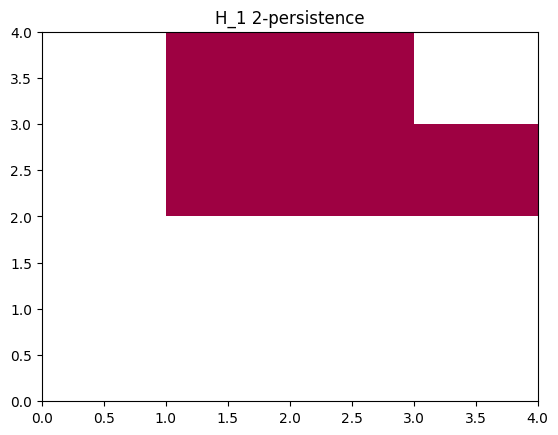

In [13]:
bimodule_approximation.plot(dimension=1);

The `image` function takes the following parameters :
- `dimension=-1` The homology dimension to plot (by default all dimension are showed)
- `resolution =[100,100]` the resolution of the image.
- `bandwidth=1` The bandwidth smoothing parameter.
- `plot=True` If true, plots the image.
- `p=0` If positive, will increase the weight of the larger summands.
- `box` Can be used to "zoom" into the original box.
- several matplotlib flags.

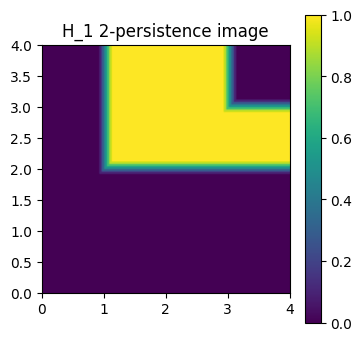

In [14]:
bimodule_approximation.image(dimension=1, bandwidth=0.1, cb=1);

**Remark:** Multiparameter persistence landscapes can also be computed from modules, using the `landscape` and `landscapes` functions.

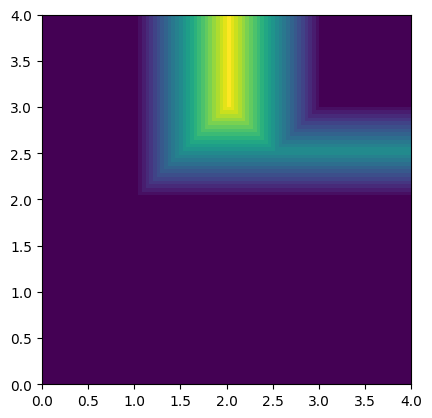

In [16]:
bimodule_approximation.landscape(dimension=1, k=0);

**Remark:** 1-dimensional barcodes can also be efficiently sliced from a module, using the `barcode` and `barcodes` method. Note that when the approximation module is computed over a box that is too small, the barcodes outside the box are bot guaranteed to be exact.

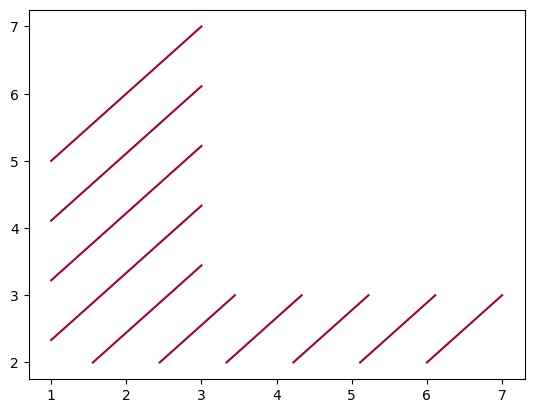

In [27]:
bimodule_approximation.barcodes(num=10, dimension=1).plot()

For approximation examples, see the notebook `examples_of_approximations`

## Typical bi-filtration : Rips/Alpha + density

In [28]:
from mma import noisy_annulus
from sklearn.neighbors import KernelDensity

The noisy annulus dataset that we consider

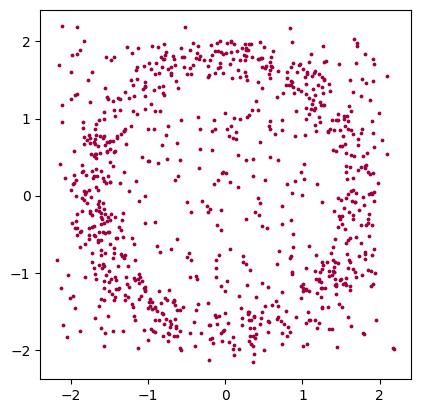

In [29]:
npts = 500
noutliers = (int)(npts * 0.4)
np.random.seed(100)
X = np.block([[np.array(noisy_annulus(1.5,2, npts))], [np.random.uniform(low=-2, high=2, size=(noutliers,2))]] )
fig, ax = plt.subplots()
ax.set_aspect('equal')
plt.scatter(X[:,0], X[:,1],s=3)
plt.show()

In [30]:
# Defines an alpha complex from the point cloud
ac = gd.AlphaComplex(points=X)
simplextree = ac.create_simplex_tree()

# For computational efficiency, alpha complexes can change the order of the points
X = np.array([ac.get_point(i) for i in  range(simplextree.num_vertices())])


# Estimates the density of the point cloud
kde = KernelDensity(kernel='gaussian', bandwidth=1/4).fit(X)

# Retrieves the boundary and the filtration from the simplextree
boundary, alpha_filtration = splx2bf(simplextree)

# Defines the bifiltration
codensity_fitlration = -np.array(kde.score_samples(X))
F=[alpha_filtration,codensity_fitlration]

# The box on which to compute
box = [[0,1.5], [0.4,5]]

# Computes an approximation of the module
bimodule = approx(boundary, F, box=box, precision=0.001, verbose = 0)

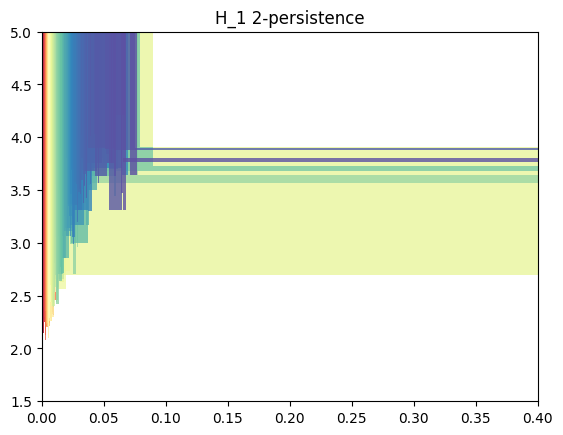

In [31]:
bimodule.plot(alpha=0.8, dimension=1, save="fig_1.png", dpi=200);

The annulus clearly appears :)

The $x$ axis is the alpha complex filtration, and the $y$ axis is the co-log-density (a simplex will appear earlier if it has a bigger density value) 

We can see in that example that there is only 1 significant (green) summand of dimension 1 representing the circle.

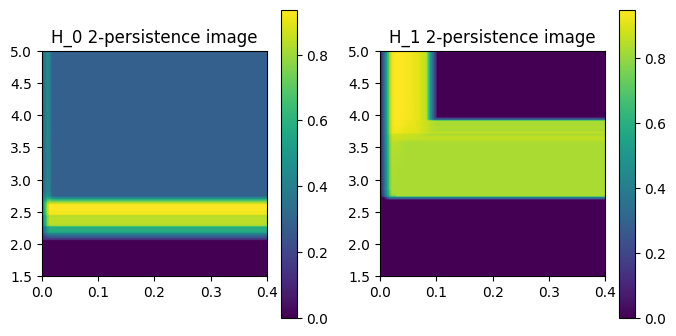

In [32]:
bimodule.image(bandwidth=0.01, p=2, colorbar=1);

## Higher dimensions

The same syntax applies in higher persistence dimension : 

In [33]:
max_dim = 4
# We take a random filtration of the form
F = [[np.random.uniform(low = 0, high = 1) for _ in range(simplextree.num_vertices())] for _ in range(max_dim)]
# And a random box of the same dimension 
box = [[np.random.uniform(low = 0, high = 1) for _ in range(max_dim)], [np.random.uniform(low = 2, high = 3)for _ in range(max_dim)]]
precision=1

In [34]:
%time n_mod_approximation = approx(simplextree, F, precision, box);

CPU times: user 4.03 s, sys: 13.4 ms, total: 4.04 s
Wall time: 4.03 s


But there is no plotting function in higher dimension.